In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
from sklearn import svm
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np
from pyrsgis import raster
from pyrsgis import ml
import random
from copy import copy
from itertools import cycle
from osgeo import gdal

In [2]:
featurefile = r'E:/Sentinel2/Sistan_Sentinel.tif'

In [3]:
lablefile = r'E:/Sentinel2/Sistan_Sentinel_Training.tif'

In [4]:
dsfeature , arrayfeature = raster.read(featurefile, bands = 'all')
arrayfeature = arrayfeature.astype(float)

In [5]:
print(arrayfeature)

[[[2112. 2070. 2056. ... 2527. 2510. 2522.]
  [2117. 2102. 2065. ... 2532. 2585. 2622.]
  [2125. 2125. 2116. ... 2545. 2543. 2592.]
  ...
  [1397. 1411. 1417. ... 2112. 2095. 2083.]
  [1454. 1442. 1470. ... 2085. 2096. 2086.]
  [1574. 1491. 1475. ... 2088. 2097. 2104.]]

 [[2308. 2288. 2270. ... 2888. 2868. 2850.]
  [2345. 2294. 2290. ... 2887. 2938. 2968.]
  [2352. 2349. 2333. ... 2915. 2913. 2962.]
  ...
  [1381. 1387. 1412. ... 2364. 2349. 2335.]
  [1437. 1456. 1471. ... 2357. 2343. 2342.]
  [1582. 1499. 1500. ... 2351. 2356. 2338.]]

 [[2745. 2711. 2721. ... 3568. 3536. 3547.]
  [2752. 2719. 2746. ... 3549. 3563. 3636.]
  [2796. 2756. 2762. ... 3549. 3587. 3665.]
  ...
  [1482. 1521. 1555. ... 2882. 2837. 2836.]
  [1582. 1607. 1599. ... 2869. 2869. 2847.]
  [1805. 1649. 1637. ... 2858. 2853. 2830.]]

 ...

 [[3002. 3002. 2976. ... 3866. 3931. 3931.]
  [3002. 3002. 2976. ... 3866. 3931. 3931.]
  [2941. 2941. 2920. ... 3919. 3909. 3909.]
  ...
  [1723. 1723. 1680. ... 3024. 3012. 301

In [6]:
arrayfeature.shape

(10, 866, 770)

In [7]:
for i in range(arrayfeature.shape[0]):
 minb = arrayfeature [i][:][:].min()
 maxb = arrayfeature [i][:][:].max()
 rangeb = maxb - minb
 for j in range(arrayfeature.shape[1]):
    for k in range(arrayfeature.shape[2]):
        arrayfeature[i][j][k] = (arrayfeature[i][j][k] - minb)/rangeb

In [8]:
print(arrayfeature)

[[[0.46893975 0.44932275 0.44278375 ... 0.6627744  0.65483419 0.66043905]
  [0.47127511 0.46426903 0.44698739 ... 0.66510976 0.68986455 0.70714619]
  [0.47501168 0.47501168 0.47080803 ... 0.67118169 0.67024755 0.69313405]
  ...
  [0.13498365 0.14152265 0.14432508 ... 0.46893975 0.46099953 0.45539468]
  [0.16160673 0.15600187 0.16907987 ... 0.45632882 0.4614666  0.45679589]
  [0.2176553  0.17888837 0.17141523 ... 0.45773003 0.46193368 0.46520318]]

 [[0.48655617 0.47918969 0.47255985 ... 0.70018416 0.69281768 0.68618785]
  [0.50018416 0.48139963 0.47992634 ... 0.69981584 0.71860037 0.72965009]
  [0.50276243 0.50165746 0.49576427 ... 0.71012891 0.70939227 0.72744015]
  ...
  [0.14511971 0.14732965 0.15653775 ... 0.50718232 0.50165746 0.49650092]
  [0.16574586 0.17274401 0.17826888 ... 0.50460405 0.49944751 0.49907919]
  [0.21915285 0.18858195 0.18895028 ... 0.50239411 0.50423573 0.49760589]]

 [[0.49627721 0.48654066 0.48940435 ... 0.73195876 0.72279496 0.72594502]
  [0.49828179 0.488831

In [9]:
print (arrayfeature.shape)

(10, 866, 770)


In [10]:
features = ml.array_to_chips(arrayfeature, y_size=7, x_size=7)

In [11]:
features.shape

(666820, 7, 7, 10)

In [12]:
dslable, arraylable = raster.read(lablefile)

In [13]:
np.unique(arraylable)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 255], dtype=uint8)

In [14]:
arraylable[arraylable==255]=0

In [15]:
np.unique(arraylable)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [16]:
arraylable = arraylable.flatten()

In [17]:
arraylable.shape

(666820,)

In [18]:
features = features[arraylable != 0]
lable = arraylable[arraylable != 0]

In [19]:
np.unique(lable)

array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [20]:
slin = int(features.shape[0] * 0.70)

In [21]:
slin

27069

In [22]:
def train_test_split(features, lable, trainprob = 0.70):
    datasize = features.shape[0]
    sliceindex = int(datasize * trainprob)
    randindex = np.arange(datasize)
    random.shuffle(randindex)
    train_x = features[[randindex[:sliceindex]],:,:,:][0]
    test_x = features[[randindex[sliceindex:]],:,:,:][0]
    train_y = lable[randindex[:sliceindex]]
    test_y = lable[randindex[sliceindex:]]
    return(train_x, train_y, test_x, test_y)

In [23]:
train_x, train_y, test_x, test_y = train_test_split(features, lable)

In [24]:
print(train_x)
print(train_y)
print(test_x)
print(test_y)

[[[[0.51097618 0.51012891 0.54295533 ... 0.51096621 0.51015343
    0.53612678]
   [0.48528725 0.53775322 0.52348225 ... 0.50266746 0.49796931
    0.52511416]
   [0.49509575 0.49981584 0.49856816 ... 0.50266746 0.49796931
    0.52511416]
   ...
   [0.43904717 0.42615101 0.41237113 ... 0.44457617 0.44517148
    0.44802579]
   [0.42363382 0.41657459 0.40549828 ... 0.38648488 0.39778881
    0.38275584]
   [0.42970574 0.43278085 0.41294387 ... 0.38648488 0.39778881
    0.38275584]]

  [[0.52638954 0.52928177 0.53293242 ... 0.51096621 0.51015343
    0.53612678]
   [0.4549276  0.48802947 0.48883162 ... 0.50266746 0.49796931
    0.52511416]
   [0.47314339 0.48213628 0.47909507 ... 0.50266746 0.49796931
    0.52511416]
   ...
   [0.45913125 0.45230203 0.45504009 ... 0.44457617 0.44517148
    0.44802579]
   [0.43297525 0.43720074 0.430126   ... 0.38648488 0.39778881
    0.38275584]
   [0.45539468 0.45451197 0.43671249 ... 0.38648488 0.39778881
    0.38275584]]

  [[0.52405418 0.53075506 0.528636

In [25]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(27069, 7, 7, 10)
(27069,)
(11602, 7, 7, 10)
(11602,)


In [26]:
import tensorflow as tf

In [27]:
model =  tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size = 1, padding = 'valid', activation = 'relu',
                                 input_shape = (train_x.shape[1], train_x.shape[2], train_x.shape[3])))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv2D(48, kernel_size = 1, padding = 'valid', activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation = 'softmax'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 7, 7, 32)          352       
                                                                 
 dropout (Dropout)           (None, 7, 7, 32)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 48)          1584      
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 48)          0         
                                                                 
 flatten (Flatten)           (None, 2352)              0         
                                                                 
 dense (Dense)               (None, 64)                150592    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

In [28]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
model.fit(train_x, train_y, epochs =20)

Epoch 1/20
846/846 [==============================] - 11s 9ms/step - loss: 0.8134 - accuracy: 0.7331
Epoch 2/20
846/846 [==============================] - 8s 10ms/step - loss: 0.4194 - accuracy: 0.8547
Epoch 3/20
846/846 [==============================] - 8s 9ms/step - loss: 0.3261 - accuracy: 0.8877
Epoch 4/20
846/846 [==============================] - 9s 10ms/step - loss: 0.2835 - accuracy: 0.9039
Epoch 5/20
846/846 [==============================] - 8s 10ms/step - loss: 0.2462 - accuracy: 0.9141
Epoch 6/20
846/846 [==============================] - 8s 10ms/step - loss: 0.2314 - accuracy: 0.9234
Epoch 7/20
846/846 [==============================] - 8s 10ms/step - loss: 0.2209 - accuracy: 0.9265
Epoch 8/20
846/846 [==============================] - 8s 10ms/step - loss: 0.1980 - accuracy: 0.9355
Epoch 9/20
846/846 [==============================] - 8s 9ms/step - loss: 0.1895 - accuracy: 0.9389
Epoch 10/20
846/846 [==============================] - 8s 9ms/step - loss: 0.1782 - accuracy:

In [33]:
dspre , featurepre = raster.read(r'E:/Sentinel2/Sistan_Sentinel.tif')
featurepre = featurepre.astype(float)

In [35]:
for i in range(featurepre.shape[0]):
 minb = featurepre [i][:][:].min()
 maxb = featurepre [i][:][:].max()
 rangeb = maxb - minb
 for j in range(featurepre.shape[1]):
    for k in range(featurepre.shape[2]):
        featurepre[i][j][k] = (featurepre[i][j][k] - minb)/rangeb

In [36]:
new_features = ml.array_to_chips(featurepre, x_size = 7, y_size = 7)

In [37]:
newpredicted = model.predict(new_features)

20839/20839 [==============================] - 103s 5ms/step


In [45]:
prediction = np.reshape(newpredicted.argmax(axis = 1), (dspre.RasterYSize, dspre.RasterXSize))

In [46]:
prediction.shape

(866, 770)

In [48]:
outfile = r'E:/Sentinel2/CNN.tif'
raster. export(prediction, dspre, filename = outfile, dtype = 'float')

In [49]:
cnn_map = prediction
print(cnn_map.shape)

(866, 770)


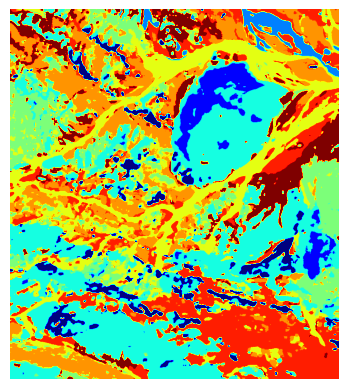

In [52]:
plt.figure()
plt.imshow(cnn_map, cmap = 'jet')
plt.axis('off')
plt.show()